## Imports


In [1]:
import os
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
from tqdm.notebook import tqdm

from bergson.data import load_gradients
from safetensors.torch import load_file

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

import json

## Paths + Helper function



In [2]:
# merged medical

index_path = "/mnt/ssd-1/gpaulo/emergent-misalignment/qwen14_merged_medical/merged_medical"
# ekfac_query_path = (
#     "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_medical/query95a3930f07f9889712dc2a3e565000f1"
# )


query_data_path_csv = (
    "/mnt/ssd-1/gpaulo/emergent-misalignment/emergent-misalignment-eleuther/open_models/merged_medical_llama.csv"
)

In [3]:
# # merged code

# index_path = "/mnt/ssd-1/gpaulo/emergent-misalignment/qwen14_merged_code/merged_code"
# # ekfac_query_path = (
# #     "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_code/queryfa2c3e9d26bc41cf6a9bf1b45f43b9db"
# # )

# ekfac_query_path = "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_code/query07e71a09354a6b9e89561ff6bec946ac"  # using eval for ekfac
# query_path = "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_code/query_proj16"


# query_data_path_csv = (
#     "/mnt/ssd-1/gpaulo/emergent-misalignment/emergent-misalignment-eleuther/open_models/merged_code_completions.csv"
# )

In [4]:
query_ekfac_eval = (
    "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_medical/query_55062c362f3a1ffe20016662f3ca5f0c"
)
query_ekfac_train = (
    "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_medical/query_d8ab5e0b71ab9fc4f54f58e6e4941898"
)
query_raw = "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_medical_cache/query_proj16"
query_ekfac_with_attn_eval = (
    "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_medical/query_253b5a8f9e5918aa3acfe7aedaaa4842"
)
query_ekfac_with_attn_train = (
    "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_medical/query_be8b5324283cf3e71560d50453797a25"
)

In [5]:
def compute_attribution(query_path, index_path, query_data_path_csv, unit_norm=True):
    df_alignment_scores = pd.read_csv(query_data_path_csv)
    index = load_gradients(index_path)
    queries = load_gradients(query_path)

    names_index = index.dtype.names
    names_queries = queries.dtype.names

    names_intersection = list(set(names_index).intersection(set(names_queries)))

    index_tensor = torch.cat(
        [torch.from_numpy(index[name]).to("cuda", dtype=torch.float32) for name in names_intersection], dim=1
    )  # ( num_index, dim)

    query_tensor = torch.cat(
        [torch.from_numpy(queries[name]).to("cuda", dtype=torch.float32) for name in names_intersection], dim=1
    )  # ( num_query, dim)

    if unit_norm:
        index_tensor = index_tensor / index_tensor.norm(dim=1, keepdim=True)
        query_tensor = query_tensor / query_tensor.norm(dim=1, keepdim=True)

    attributions = torch.einsum("qd,id->iq", query_tensor, index_tensor).cpu().numpy()

    average_question_alignment = df_alignment_scores.groupby("question_id")["aligned"].mean()

    df_alignment_scores["advantage"] = (
        df_alignment_scores["question_id"].map(average_question_alignment) - df_alignment_scores["aligned"]
    )

    attributions_scores = np.nanmean(attributions * df_alignment_scores["advantage"].values, axis=1)

    return attributions_scores

In [6]:
def spearman_correlation_plot(scores1, scores2, label1="Scores 1", label2="Scores 2", figsize=(10, 8), title=None):
    """
    Calculate Spearman correlation between two score arrays and create a scatter plot.

    Args:
        scores1 (array-like): First set of scores
        scores2 (array-like): Second set of scores
        label1 (str): Label for first scores (x-axis)
        label2 (str): Label for second scores (y-axis)
        figsize (tuple): Figure size for the plot

    Returns:
        tuple: (spearman_correlation, p_value)
    """

    # Convert to numpy arrays if needed
    scores1 = np.array(scores1)
    scores2 = np.array(scores2)

    # Remove NaN values
    mask = ~(np.isnan(scores1) | np.isnan(scores2))
    clean_scores1 = scores1[mask]
    clean_scores2 = scores2[mask]

    if len(clean_scores1) == 0:
        print("Error: No valid data points after removing NaN values")
        return None, None

    # Calculate Spearman correlation
    spearman_corr, p_value = spearmanr(clean_scores1, clean_scores2)

    print(f"Spearman Correlation: {spearman_corr:.4f}")
    print(f"P-value: {p_value:.2e}")
    print(f"Number of valid pairs: {len(clean_scores1)}")

    # Create scatter plot
    plt.figure(figsize=figsize)
    plt.scatter(clean_scores1, clean_scores2, alpha=0.6, s=30)
    plt.xlabel(label1)
    plt.ylabel(label2)
    plt.title(f"Spearman Correlation {title}: ρ = {spearman_corr:.4f}, p = {p_value:.2e}")
    plt.grid(True, alpha=0.3)

    # Add trend line
    z = np.polyfit(clean_scores1, clean_scores2, 1)
    trend_line = np.poly1d(z)
    plt.plot(clean_scores1, trend_line(clean_scores1), "r--", alpha=0.8, linewidth=2, label="Trend line")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return spearman_corr, p_value


# Usage examples:
# corr, p_val = spearman_correlation_plot(attributions_scores, attributions_ekfac_scores)
#
# # With custom labels:
# corr, p_val = spearman_correlation_plot(
#     attributions_scores,
#     attributions_ekfac_scores,
#     label1="Attribution Scores",
#     label2="Attribution EKFAC Scores"
# )

## Compare two query types

In [9]:
# load csv
df_alignment_scores = pd.read_csv(query_data_path_csv)
index = load_gradients(index_path)

In [11]:
queries = load_gradients(query_path)

queries_ekfac = load_gradients(query_ekfac_with_attn_eval)

In [13]:
names_index = index.dtype.names
names_queries = queries.dtype.names
names_queries_ekfac = queries_ekfac.dtype.names

names_intersection = list(set(names_index).intersection(set(names_queries)))
names_intersection_ekfac = list(set(names_index).intersection(set(names_queries_ekfac)))


In [14]:
# names_intersection = [n for n in names_intersection if "attn" not in n]
# names_intersection_ekfac = [n for n in names_intersection_ekfac if "attn" not in n]

In [15]:
unit_norm = True


index_tensor = torch.cat(
    [torch.from_numpy(index[name]).to("cuda", dtype=torch.float32) for name in names_intersection], dim=1
)  # ( num_index, dim)

index_tensor_ekfac = torch.cat(
    [torch.from_numpy(index[name]).to("cuda", dtype=torch.float32) for name in names_intersection_ekfac], dim=1
)

query_tensor = torch.cat(
    [torch.from_numpy(queries[name]).to("cuda", dtype=torch.float32) for name in names_intersection], dim=1
)  # ( num_query, dim)

query_tensor_ekfac = torch.cat(
    [torch.from_numpy(queries_ekfac[name]).to("cuda", dtype=torch.float32) for name in names_intersection_ekfac], dim=1
)  # ( num_query, dim)

if unit_norm:
    index_tensor = index_tensor / index_tensor.norm(dim=1, keepdim=True)
    query_tensor = query_tensor / query_tensor.norm(dim=1, keepdim=True)
    query_tensor_ekfac = query_tensor_ekfac / query_tensor_ekfac.norm(dim=1, keepdim=True)


attributions = torch.einsum("qd,id->iq", query_tensor, index_tensor)
attributions_ekfac = torch.einsum("qd,id->iq", query_tensor_ekfac, index_tensor_ekfac)

/tmp/ipykernel_760914/2000273760.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  [torch.from_numpy(index[name]).to("cuda", dtype=torch.float32) for name in names_intersection], dim=1


In [16]:
attributions_ekfac = attributions_ekfac.cpu().numpy()
attributions = attributions.cpu().numpy()

In [17]:
average_question_alignment = df_alignment_scores.groupby("question_id")["aligned"].mean()

df_alignment_scores["advantage"] = (
    df_alignment_scores["question_id"].map(average_question_alignment) - df_alignment_scores["aligned"]
)


In [18]:
attributions_scores = np.nanmean(attributions * df_alignment_scores["advantage"].values, axis=1)
attributions_ekfac_scores = np.nanmean(attributions_ekfac * df_alignment_scores["advantage"].values, axis=1)

Spearman Correlation: 0.8247
P-value: 0.00e+00


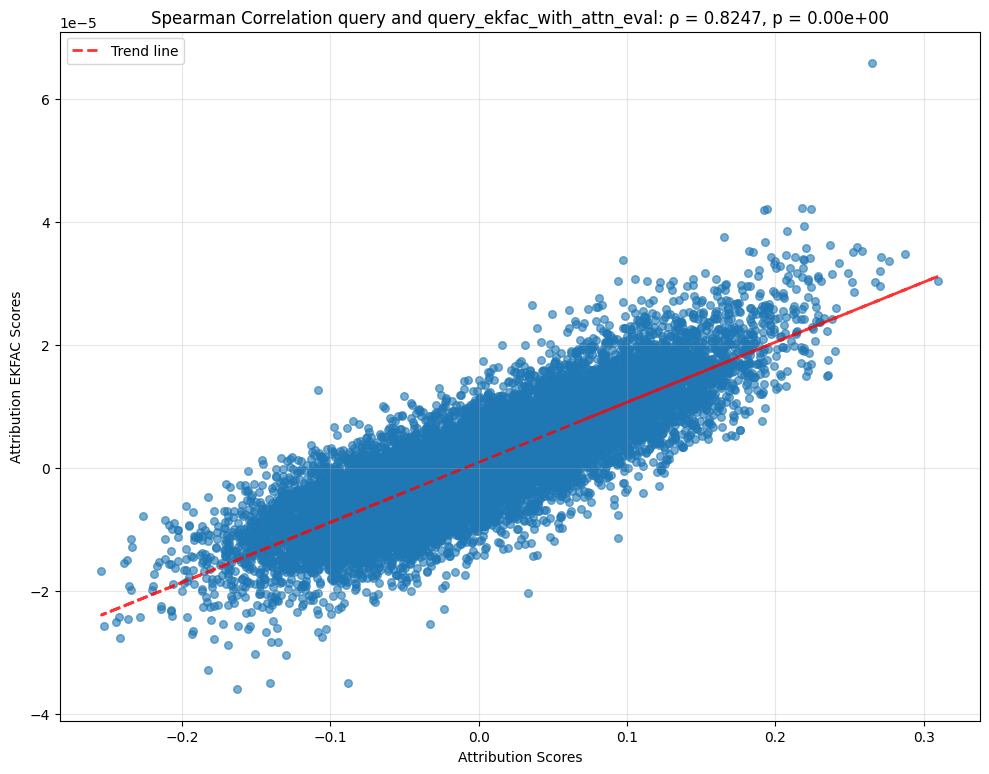

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Calculate Spearman correlation
mask = ~(np.isnan(attributions_scores) | np.isnan(attributions_ekfac_scores))
clean_scores1 = attributions_scores[mask]
clean_scores2 = attributions_ekfac_scores[mask]

spearman_corr, p_value = spearmanr(clean_scores1, clean_scores2)

print(f"Spearman Correlation: {spearman_corr:.4f}")
print(f"P-value: {p_value:.2e}")

# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(clean_scores1, clean_scores2, alpha=0.6, s=30)
plt.xlabel("Attribution Scores")
plt.ylabel("Attribution EKFAC Scores")
plt.title(f"Spearman Correlation query and query_ekfac_with_attn_eval: ρ = {spearman_corr:.4f}, p = {p_value:.2e}")
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(clean_scores1, clean_scores2, 1)
p = np.poly1d(z)
plt.plot(clean_scores1, p(clean_scores1), "r--", alpha=0.8, linewidth=2, label="Trend line")
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
top_percentages = [0.001, 0.01, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 0.9, 0.99, 0.999]

intersections = []
intersections_ekfac = []

intersections_random = []

for perc in top_percentages:
    # top x percent indices

    top_k = int(perc * len(index))  # top 10%
    # _, top_indices = torch.topk(attribution_query, top_k) # mean over all components
    top_indices = np.argpartition(attributions_scores, -top_k)[-top_k:]
    top_indices_ekfac = np.argpartition(attributions_ekfac_scores, -top_k)[-top_k:]

    intersection_ekfac = (top_indices_ekfac < (len(index) // 2)).sum()
    intersection = (top_indices < (len(index) // 2)).sum()
    intersections.append(intersection.item())
    intersections_ekfac.append(intersection_ekfac.item())

    # random baseline
    random_indices = torch.randperm(len(index))[:top_k]
    intersection_random = (random_indices < (len(index) // 2)).sum()
    intersections_random.append(intersection_random.item())


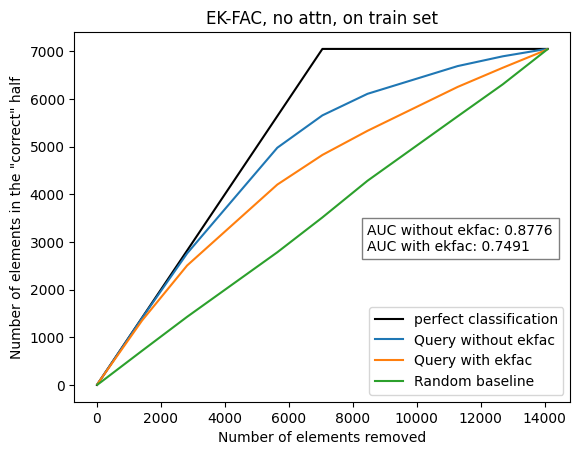

In [33]:
plt.plot(
    [0, len(index) // 2, len(index)],
    [0, len(index) // 2, len(index) // 2],
    label="perfect classification",
    color="black",
)


plt.plot(np.array(top_percentages) * len(index), intersections, label=f"Query without ekfac")
plt.plot(np.array(top_percentages) * len(index), intersections_ekfac, label=f"Query with ekfac")
plt.plot(np.array(top_percentages) * len(index), intersections_random, label=f"Random baseline")
plt.xlabel("Number of elements removed")
plt.ylabel('Number of elements in the "correct" half')
plt.title("EK-FAC, no attn, on train set")


plt.legend()


# add auc to the plot
from sklearn.metrics import roc_auc_score

y_true = np.array([1] * (len(index) // 2) + [0] * (len(index) // 2))
roc_auc = roc_auc_score(y_true, attributions_scores)
roc_auc_ekfac = roc_auc_score(y_true, attributions_ekfac_scores)
plt.text(
    len(index) * 0.6,
    len(index) * 0.2,
    f"AUC without ekfac: {roc_auc:.4f}\nAUC with ekfac: {roc_auc_ekfac:.4f}",
    bbox=dict(facecolor="white", alpha=0.5),
)

plt.show()

In [32]:
from sklearn.metrics import roc_auc_score

y_true = np.array([1] * (len(index) // 2) + [0] * (len(index) // 2))
roc_auc = roc_auc_score(y_true, attributions_scores)
roc_auc_ekfac = roc_auc_score(y_true, attributions_ekfac_scores)
print(f"ROC AUC without ekfac: {roc_auc}")
print(f"ROC AUC with ekfac: {roc_auc_ekfac}")

ROC AUC without ekfac: 0.8776147978680175
ROC AUC with ekfac: 0.749104806169955


## Computing attribution tensors

In [7]:
# # merged_medical
# all_query_paths = [
#     query_ekfac_with_attn_eval,
#     query_ekfac_with_attn_train,
#     query_raw,
#     query_ekfac_eval,
#     query_ekfac_train,
# ]

In [8]:
# bad_financial
all_query_paths = [
    "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/bad_financial/query_2e1ef384b013061f04ed0e8c826e4f82"
]

index_path = "/mnt/ssd-1/gpaulo/emergent-misalignment/qwen14_financial/financial"
query_data_path_csv = "/mnt/ssd-1/gpaulo/emergent-misalignment/emergent-misalignment-eleuther/open_models/financial.csv"

In [9]:
for path in all_query_paths:
    print(f"Computing attributions for {path}")
    attributions_scores = compute_attribution(path, index_path, query_data_path_csv, unit_norm=True)
    # save to a file
    config_path = path + "/config.json"
    config = json.load(open(config_path))
    key = os.path.basename(config["ekfac_path"])
    # path_final = os.path.basename(path)
    path_final = f"query_{key}"

    np.save(path_final + "_attributions_scores.npy", attributions_scores)
    print(f"Saved to {path_final}_attributions_scores.npy")

Computing attributions for /mnt/ssd-1/louis/emergent_misalignment/gradients_data/bad_financial/query_2e1ef384b013061f04ed0e8c826e4f82


/tmp/ipykernel_1772656/674876198.py:12: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  [torch.from_numpy(index[name]).to("cuda", dtype=torch.float32) for name in names_intersection], dim=1


Saved to query_ekfac_bad_financial_eval_with_attn_attributions_scores.npy


In [14]:
# load the saved attributions
import json


all_attributions = {}

for path in all_query_paths:
    config_path = path + "/config.json"
    config = json.load(open(config_path))
    key = os.path.basename(config["ekfac_path"])

    path_final = f"query_{key}"
    attributions_scores = np.load(path_final + "_attributions_scores.npy")

    all_attributions[key] = attributions_scores

In [10]:
index = load_gradients(index_path)


In [11]:
intersections_dict = {}

top_percentages = [0.001, 0.01, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 0.9, 0.99, 0.999]

for key, attributions in all_attributions.items():
    intersections = []
    for perc in top_percentages:
        top_k = int(perc * len(index))
        top_indices = np.argpartition(attributions, -top_k)[-top_k:]
        intersection = (top_indices < (len(index) // 2)).sum()
        intersections.append(intersection.item())
    intersections_dict[key] = intersections

# add random baseline
intersections_random = []
for perc in top_percentages:
    top_k = int(perc * len(index))
    random_indices = torch.randperm(len(index))[:top_k]
    intersection_random = (random_indices < (len(index) // 2)).sum()
    intersections_random.append(intersection_random.item())
intersections_dict["random"] = intersections_random


NameError: name 'all_attributions' is not defined

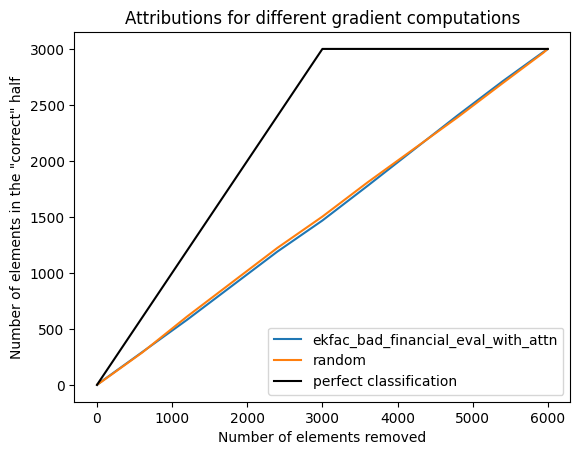

In [17]:
# plot all the intersections
for key, intersections in intersections_dict.items():
    plt.plot(np.array(top_percentages) * len(index), intersections, label=key)
plt.plot(
    [0, len(index) // 2, len(index)],
    [0, len(index) // 2, len(index) // 2],
    label="perfect classification",
    color="black",
)
plt.xlabel("Number of elements removed")
plt.ylabel('Number of elements in the "correct" half')
plt.title("Attributions for different gradient computations")
plt.legend()
plt.show()


In [23]:
all_attributions.keys()

dict_keys(['ekfac_merged_medical_eval_with_attn', 'ekfac_merged_medical_train_with_attn', 'no_ekfac', 'ekfac_merged_medical_eval', 'ekfac_merged_medical_train'])

Spearman Correlation: 0.5967
P-value: 0.00e+00
Number of valid pairs: 14098


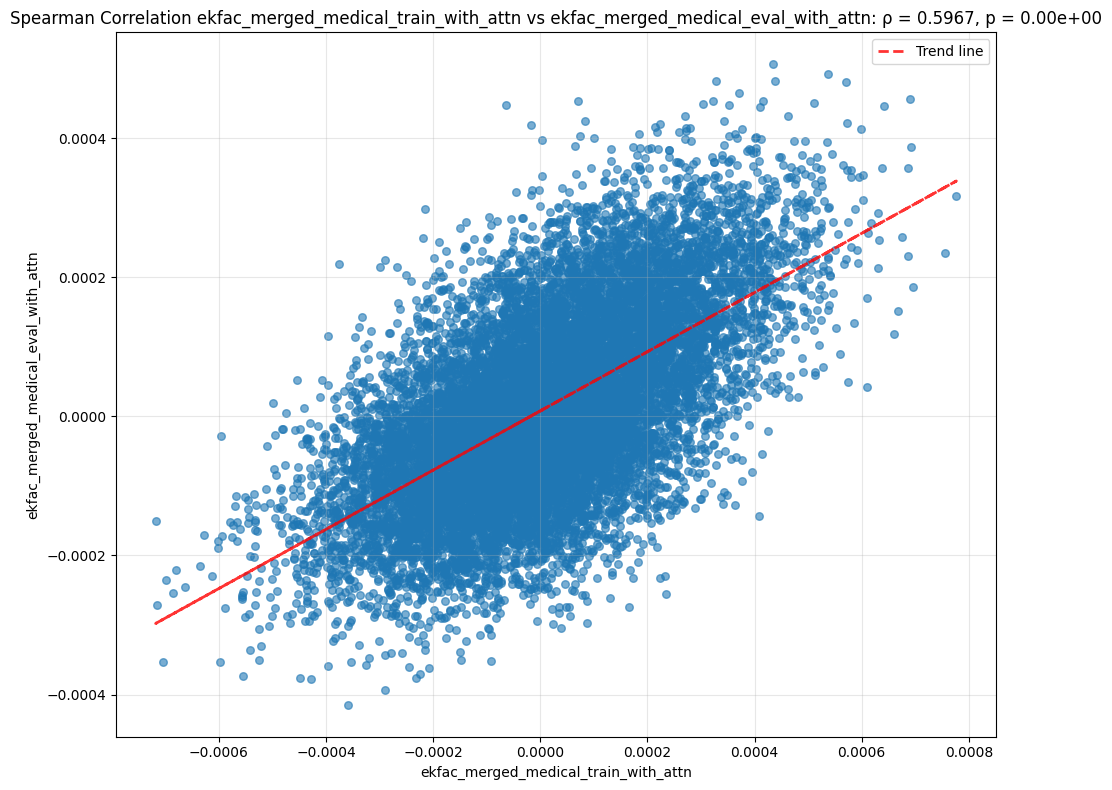

(0.5966791721373077, 0.0)

In [24]:
label1 = "ekfac_merged_medical_train_with_attn"
label2 = "ekfac_merged_medical_eval_with_attn"

spearman_correlation_plot(
    all_attributions[label1],
    all_attributions[label2],
    label1=label1,
    label2=label2,
    title=label1 + " vs " + label2,
)

In [25]:
attributions_1 = all_attributions["no_ekfac"]
attributions_2 = all_attributions["ekfac_merged_medical_eval_with_attn"]
intersection_12 = []

for perc in top_percentages:
    top_k = int(perc * len(index))
    top_indicies_1 = np.argpartition(attributions_1, -top_k)[-top_k:]

    top_indicies_2 = np.argpartition(attributions_2, -top_k)[-top_k:]

    intersection = len(set(top_indicies_1).intersection(set(top_indicies_2)))
    intersection_12.append(intersection)


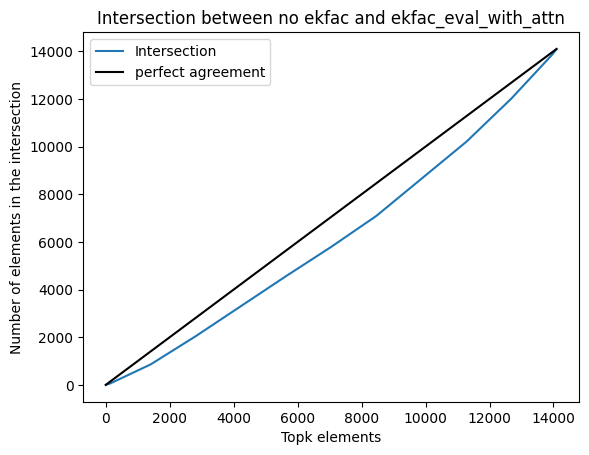

In [26]:
# plot intersection
plt.plot(np.array(top_percentages) * len(index), intersection_12, label=f"Intersection")
plt.plot(
    [0, len(index) // 2, len(index)],
    [0, len(index) // 2, len(index)],
    label="perfect agreement",
    color="black",
)
plt.xlabel("Topk elements")
plt.ylabel("Number of elements in the intersection")
plt.title("Intersection between no ekfac and ekfac_eval_with_attn")
plt.legend()
plt.show()

## Compute new attributions

In [89]:
attribution_query = torch.zeros((len(index)), device="cuda")
attribution_ekfac_query = torch.zeros((len(index)), device="cuda")

In [120]:
attribution_query = torch.zeros((len(index)), device="cuda")
attribution_ekfac_query = torch.zeros((len(index)), device="cuda")
dict_of_attributions_ekfac = {}
dict_of_attributions = {}
normalize = True
for name in names:
    index_tensor = torch.from_numpy(index[name]).to("cuda", dtype=torch.float32)  # ( num_index, dim)
    query_tensor_ekfac = torch.from_numpy(queries_ekfac[name]).to("cuda")  # ( num_query, dim)
    query_tensor = torch.from_numpy(queries[name]).to("cuda", dtype=torch.float32)  # ( num_query, dim)

    if normalize:
        index_tensor = index_tensor / (index_tensor.norm(dim=-1, keepdim=True) + 1e-10)
        query_tensor_ekfac = query_tensor_ekfac / (query_tensor_ekfac.norm(dim=-1, keepdim=True) + 1e-10)
        query_tensor = query_tensor / (query_tensor.norm(dim=-1, keepdim=True) + 1e-10)

    dot_product_ekfac = torch.einsum("qd,id->qi", query_tensor_ekfac, index_tensor)  # (num_query, num_index)
    dot_product = torch.einsum("qd,id->qi", query_tensor, index_tensor)  # (num_query, num_index)

    # weight by advantages
    weighted_dot_ekfac = torch.einsum("qi,q->qi", dot_product_ekfac, -final_advantages)  # (num_query, num_index)
    weighted_dot = torch.einsum("qi,q->qi", dot_product, -final_advantages)  # (num_query, num_index)

    dict_of_attributions_ekfac[name] = weighted_dot_ekfac.sum(dim=0)
    dict_of_attributions[name] = weighted_dot.sum(dim=0)

    # sum over queries
    attribution_ekfac_query += weighted_dot_ekfac.sum(dim=0)  # (num_index,)
    attribution_query += weighted_dot.sum(dim=0)  # (num_index,)


In [121]:
from sklearn.metrics import roc_auc_score

auc_scores_ekfac = []
auc_scores = []

for name in names:
    auc = roc_auc_score([1] * (len(index) // 2) + [0] * (len(index) // 2), dict_of_attributions[name].cpu().numpy())
    auc_ekfac = roc_auc_score(
        [1] * (len(index) // 2) + [0] * (len(index) // 2), dict_of_attributions_ekfac[name].cpu().numpy()
    )
    auc_scores.append(auc)
    auc_scores_ekfac.append(auc_ekfac)


In [122]:
auc_scores = torch.tensor(auc_scores)
auc_scores_ekfac = torch.tensor(auc_scores_ekfac)


In [129]:
topk_auc = []
topk_auc_ekfac = []
for k in range(1, len(names)):
    topk_indices = torch.topk(auc_scores, k=k).indices
    topk_indices_ekfac = torch.topk(auc_scores_ekfac, k=k).indices

    list_of_attributions = list(dict_of_attributions.values())
    list_of_attributions_ekfac = list(dict_of_attributions_ekfac.values())

    final_attribution = torch.stack([list_of_attributions[i] for i in topk_indices], dim=0)
    final_attribution_ekfac = torch.stack([list_of_attributions_ekfac[i] for i in topk_indices_ekfac], dim=0)

    mean_final_attribution = final_attribution.mean(dim=0)
    mean_final_attribution_ekfac = final_attribution_ekfac.mean(dim=0)

    final_attribution_auc = roc_auc_score(
        [1] * (len(index) // 2) + [0] * (len(index) // 2), mean_final_attribution.cpu().numpy()
    )
    final_attribution_ekfac_auc = roc_auc_score(
        [1] * (len(index) // 2) + [0] * (len(index) // 2), mean_final_attribution_ekfac.cpu().numpy()
    )

    topk_auc.append(final_attribution_auc)
    topk_auc_ekfac.append(final_attribution_ekfac_auc)

    if k == 50:
        break


In [130]:
topk_indices_ekfac

tensor([216, 264, 200, 127, 132, 243, 169,   2, 256, 188, 181, 174,  54, 242,
        113,  90, 235,  59, 125,  96,  88, 101, 155, 117, 240, 203, 106,  42,
         44, 197, 259, 226, 198, 140, 164, 146, 211,  77, 176,  87, 279, 130,
        168, 265,  80, 160,  79, 258,  98, 119])

In [131]:
topk_indices

tensor([118, 264, 106, 258, 122,  90, 281, 130, 224, 108, 220, 116,  28, 124,
        162, 114,  38, 226, 120, 241, 128, 100, 126, 225, 157, 204,   3,  79,
        155, 110, 132,  35, 255,  50,  45, 102, 254, 185, 159,  63, 247,  18,
         55, 208, 242,  34, 109, 131, 117,  19])

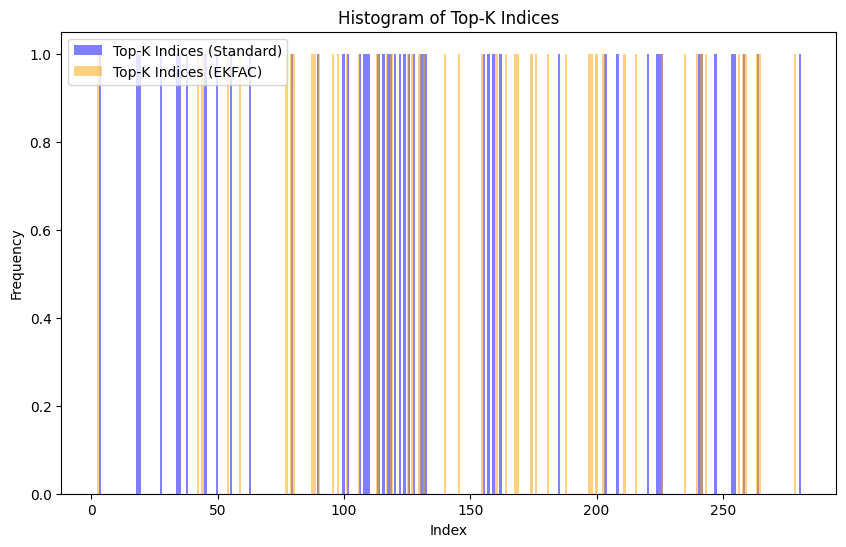

In [138]:
# Turn the top-k indices into histograms
plt.figure(figsize=(10, 6))
plt.hist(topk_indices.cpu().numpy(), bins=300, alpha=0.5, label="Top-K Indices (Standard)", color="blue")
plt.hist(topk_indices_ekfac.cpu().numpy(), bins=300, alpha=0.5, label="Top-K Indices (EKFAC)", color="orange")
plt.xlabel("Index")
plt.ylabel("Frequency")
plt.title("Histogram of Top-K Indices")
plt.legend()
plt.show()

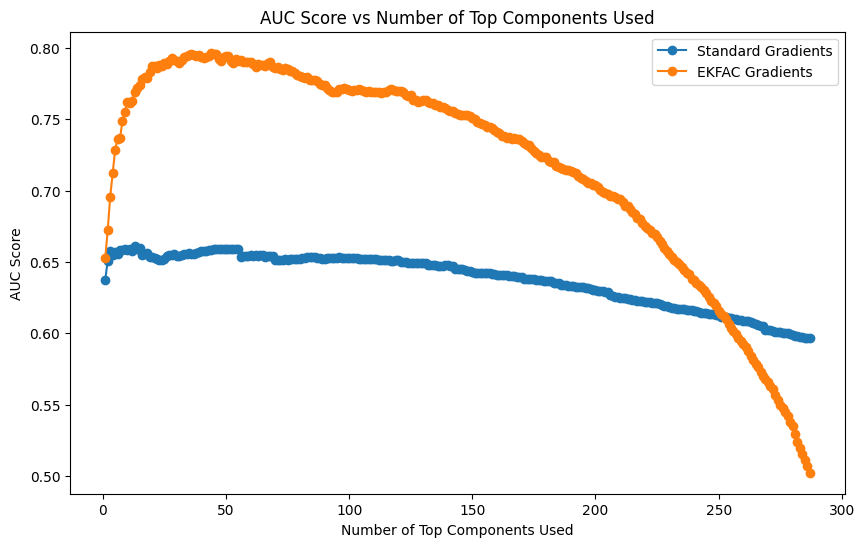

In [124]:
# plot tok_auc and topk_auc_ekfac
plt.figure(figsize=(10, 6))
plt.plot(range(1, k + 1), topk_auc, label="Standard Gradients", marker="o")
plt.plot(range(1, k + 1), topk_auc_ekfac, label="EKFAC Gradients", marker="o")
plt.xlabel("Number of Top Components Used")
plt.ylabel("AUC Score")
plt.title("AUC Score vs Number of Top Components Used")
plt.legend()
plt.show()

In [125]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score([1] * (len(index) // 2) + [0] * (len(index) // 2), mean_final_attribution.cpu().numpy())
auc

0.5963884722222224

In [126]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score([1] * (len(index) // 2) + [0] * (len(index) // 2), mean_final_attribution_ekfac.cpu().numpy())
auc


0.5021828333333334

In [86]:
top_percentages = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]  # how much to filter

intersections = []
intersections_ekfac = []

intersections_random = []

for perc in top_percentages:
    # top x percent indices

    top_k = int(perc * len(index))  # top 10%
    # _, top_indices = torch.topk(attribution_query, top_k) # mean over all components
    _, top_indices = torch.topk(mean_final_attribution, top_k)  # top k components

    # top x percent indices

    top_k = int(perc * len(index))  # top 10%
    # _, top_indices_ekfac = torch.topk(attribution_ekfac_query, top_k)
    _, top_indices_ekfac = torch.topk(mean_final_attribution_ekfac, top_k)

    intersection_ekfac = (top_indices_ekfac < (len(index) // 2)).sum()
    intersection = (top_indices < (len(index) // 2)).sum()
    intersections.append(intersection.item())
    intersections_ekfac.append(intersection_ekfac.item())

    # random baseline
    random_indices = torch.randperm(len(index))[:top_k]
    intersection_random = (random_indices < (len(index) // 2)).sum()
    intersections_random.append(intersection_random.item())


NameError: name 'mean_final_attribution' is not defined

ValueError: x and y must have same first dimension, but have shapes (7,) and (0,)

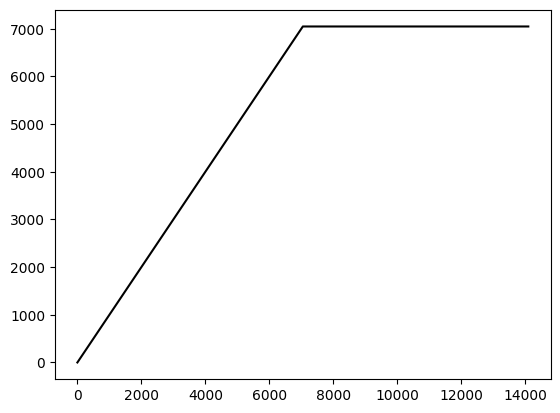

In [85]:
plt.plot(
    [0, len(index) // 2, len(index)],
    [0, len(index) // 2, len(index) // 2],
    label="perfect classification",
    color="black",
)


plt.plot(np.array(top_percentages) * len(index), intersections, label=f"Query without ekfac")
plt.plot(np.array(top_percentages) * len(index), intersections_ekfac, label=f"Query with ekfac")
plt.plot(np.array(top_percentages) * len(index), intersections_random, label=f"Random baseline")
plt.xlabel("Number of elements removed")
plt.ylabel('Number of elements in the "correct" half')
plt.legend()
plt.show()

## Compare attributions without GRPO

In [82]:
attribution_query = torch.zeros(
    (len(queries), len(index)),
    device="cuda",
)
attribution_ekfac_query = torch.zeros((len(queries), len(index)), device="cuda")

for name in names:
    index_tensor = torch.from_numpy(index[name]).to("cuda", dtype=torch.float32)  # ( num_index, dim)
    query_tensor_ekfac = torch.from_numpy(queries_ekfac[name]).to("cuda")  # ( num_query, dim)
    query_tensor = torch.from_numpy(queries[name]).to("cuda", dtype=torch.float32)  # ( num_query, dim)

    dot_product_ekfac = torch.einsum("qd,id->qi", query_tensor_ekfac, index_tensor)  # (num_query, num_index)
    dot_product = torch.einsum("qd,id->qi", query_tensor, index_tensor)  # (num_query, num_index)

    # # weight by advantages
    # weighted_dot_ekfac = torch.einsum("qi,q->qi", dot_product_ekfac, final_advantages)  # (num_query, num_index)
    # weighted_dot = torch.einsum("qi,q->qi", dot_product, final_advantages)  # (num_query, num_index)

    # sum over queries
    attribution_ekfac_query += weighted_dot_ekfac  # (num_index,)
    attribution_query += weighted_dot  # (num_index,)


In [150]:
attribution_query[0]

tensor([-2.3271e-04,  1.0354e-03,  8.2044e-04,  ...,  9.7057e-04,
        -4.9756e-05,  8.2744e-04], device='cuda:0')

In [151]:
attribution_query

tensor([[-2.3271e-04,  1.0354e-03,  8.2044e-04,  ...,  9.7057e-04,
         -4.9756e-05,  8.2744e-04],
        [ 1.0865e-04,  9.4786e-04, -2.0258e-03,  ...,  2.4611e-05,
         -2.0900e-04,  2.6817e-04],
        [ 3.3539e-04, -6.5972e-04,  1.0823e-03,  ..., -1.8786e-04,
         -4.7053e-05, -1.2034e-03],
        ...,
        [-2.3850e-04, -2.1848e-04, -1.1496e-03,  ...,  4.5910e-05,
          8.4519e-04, -6.5802e-04],
        [-1.4091e-03,  1.2724e-03,  1.9697e-03,  ...,  1.6288e-04,
          4.1683e-04,  9.3602e-04],
        [ 6.5427e-04, -5.2387e-05,  1.4312e-03,  ...,  3.2695e-04,
          4.2521e-04, -6.3714e-04]], device='cuda:0')

In [133]:
misaligned_index = df["aligned"] < 10

attribution_query_misaligned = attribution_query[misaligned_index]
attribution_ekfac_query_misaligned = attribution_ekfac_query[misaligned_index]

att_q_m_mean = attribution_query_misaligned.mean(dim=0)
att_ekfac_q_m_mean = attribution_ekfac_query_misaligned.mean(dim=0)

In [134]:
auc_query = roc_auc_score([0] * (len(index) // 2) + [1] * (len(index) // 2), att_q_m_mean.cpu().numpy())
auc_ekfac = roc_auc_score([0] * (len(index) // 2) + [1] * (len(index) // 2), att_ekfac_q_m_mean.cpu().numpy())

In [135]:
auc_query

0.5101133964846243

In [136]:
auc_ekfac

0.5287769473604111

In [137]:
att_ekfac_q_m_mean

tensor([-6.6678e-05,  3.9958e-04,  1.4910e-04,  ...,  7.2848e-04,
        -3.3071e-05,  8.3277e-05], device='cuda:0')

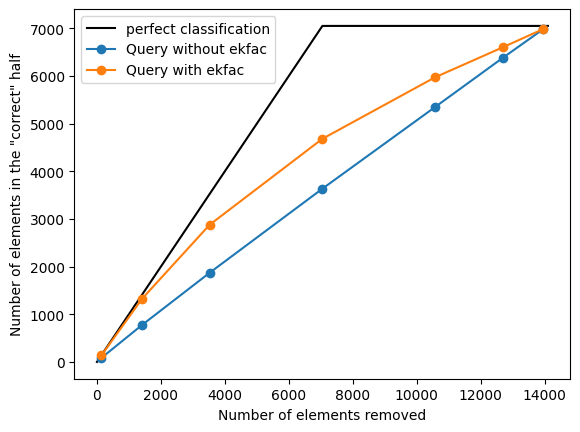

## 2. Load attribution scores

In [142]:
def overlap(
    attributions: torch.Tensor,  # shape (num_index_points, num_queries)
    aligned_queries: bool,
    top_percentages: float,
    threshold=30,
):
    query_indices = ~misaligned_index if aligned_queries else misaligned_index
    attributions_mean = attributions[:, query_indices].mean(
        dim=1
    )  # What is the average attribution of each index point to the (mis)aligned queries?

    num_elements = int(len(attributions_mean) * top_percentages)
    top_indices = torch.argsort(attributions_mean)[-num_elements:]
    bottom_indices = torch.argsort(attributions_mean)[:num_elements]

    if aligned_queries:
        overlap_top_indices = (top_indices > threshold).sum().item()
        overlap_bottom_indices = (bottom_indices <= threshold).sum().item()
    else:
        overlap_top_indices = (top_indices <= threshold).sum().item()
        overlap_bottom_indices = (bottom_indices > threshold).sum().item()

    return overlap_top_indices, overlap_bottom_indices

In [147]:
overlap(
    attribution_query.T,  # shape (num_index_points, num_queries)
    aligned_queries=True,
    top_percentages=0.5,
    threshold=len(index) // 2,
)  # for query attribution

(3834, 3835)

In [113]:
def save_plot(attributions: torch.Tensor, save_dir):
    top_percentages = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]  # how much to filter

    aligned_top_overlaps = []  # Intersection of most influential points for aligned queries with good_medical_advice
    aligned_bottom_overlaps = []  # Intersection of least influential points for aligned queries with bad_medical_advice

    misaligned_top_overlaps = []  # Intersection of most influential points for misaligned queries with bad_medical_advice
    misaligned_bottom_overlaps = []  # Intersection of least influential points for misaligned queries with good_medical_advice
    random_overlaps = []  # Intersection of random points with mixed_medical_advice

    for percentage in top_percentages:
        a_top, a_bottom = overlap(attributions, aligned_queries=True, top_percentages=percentage)
        m_top, m_bottom = overlap(attributions, aligned_queries=False, top_percentages=percentage)

        aligned_top_overlaps.append(a_top)
        aligned_bottom_overlaps.append(a_bottom)
        misaligned_top_overlaps.append(m_top)
        misaligned_bottom_overlaps.append(m_bottom)

        num_elements = int(len(index) * percentage)
        random_overlap = ((np.random.choice(len(index), size=num_elements, replace=False) >= 30).sum()).item()
        random_overlaps.append(random_overlap)

    array_len = np.array(top_percentages) * len(index)

    plt.figure(figsize=(10, 6))

    plt.plot(array_len, aligned_top_overlaps, label="aligned > aligned dataset", color="green")
    plt.plot(
        array_len,
        np.array(misaligned_top_overlaps),
        label="misaligned > misaligned dataset",
        color="red",
    )
    plt.plot(array_len, random_overlaps, label="random > aligned dataset", color="blue")
    plt.plot(
        array_len,
        aligned_bottom_overlaps,
        label="aligned bottom > misaligned dataset",
        color="green",
        linestyle="--",
    )

    plt.plot(
        array_len,
        misaligned_bottom_overlaps,
        label="misaligned bottom >aligned dataset",
        color="red",
        linestyle="--",
    )

    plt.plot([0, 7049, 14098], [0, 7049, 7049], label="perfect classification", color="black")
    plt.xlabel("Number of elements removed")
    plt.ylabel('Number of elements in the "correct" half')
    plt.legend()
    print(f"Saving plot to {save_dir}")
    plt.title("Attribution Overlap with Aligned/Misaligned Dataset")
    plt.savefig(save_dir)
    plt.close()

In [115]:
save_plot(attribution_query.T, "overlap_plot.png")

tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
tensor(2.2359e-06, device='cuda:0')
Saving plot to overlap_plot.png


In [116]:
save_dir = "/mnt/ssd-1/louis/emergent_misalignment/plots_full"
os.makedirs(save_dir, exist_ok=True)
for k, v in attribution_module_dict_tensor.items():
    print(f"Plotting for module {k}")

    save_dir_module = os.path.join(save_dir, f"{k.replace('.', '_')}.png")
    print(save_dir_module)

    save_plot(v, save_dir_module)

NameError: name 'attribution_module_dict_tensor' is not defined

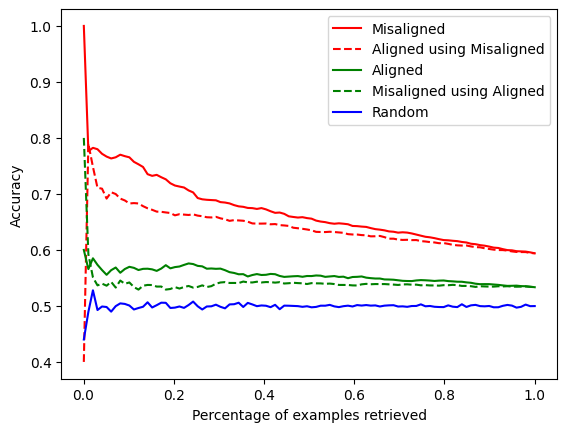

In [76]:
# compute the precision and the recall at different number of elements

average_aligned_data = attributions[:, ~misaligned_index].mean(dim=1).to(torch.float32).cpu().numpy()
average_misaligned_data = attributions[:, misaligned_index].mean(dim=1).to(torch.float32).cpu().numpy()

number_examples = np.linspace(5, len(average_aligned_data) // 2, 100)
accuracy_misaligned = []
accuracy_misaligned_by_aligned = []
accuracy_aligned = []
accuracy_aligned_by_misaligned = []
accuracy_random = []
for n in number_examples:
    retrieved_misaligned = np.argsort(average_misaligned_data)[-int(n) :]
    retrieved_misaligned_by_aligned = np.argsort(average_aligned_data)[: int(n)]
    retrieved_aligned = np.argsort(average_aligned_data)[-int(n) :]
    retrieved_aligned_by_misaligned = np.argsort(average_misaligned_data)[: int(n)]

    # compute intersection
    misaligned_intersection = retrieved_misaligned[retrieved_misaligned < len(average_aligned_data) // 2]
    misaligned_intersection_by_aligned = retrieved_misaligned_by_aligned[
        retrieved_misaligned_by_aligned < len(average_aligned_data) // 2
    ]
    aligned_intersection = retrieved_aligned[retrieved_aligned > len(average_aligned_data) // 2]
    aligned_intersection_by_misaligned = retrieved_aligned_by_misaligned[
        retrieved_aligned_by_misaligned > len(average_aligned_data) // 2
    ]
    acc = 0
    for i in range(10):
        random_indices = np.random.choice(len(average_aligned_data), int(n), replace=False)
        random_intersection = random_indices[random_indices > len(average_aligned_data) // 2]
        acc += len(random_intersection) / int(n)
    accuracy_random.append(acc / 10)
    accuracy_misaligned.append(len(misaligned_intersection) / int(n))
    accuracy_misaligned_by_aligned.append(len(misaligned_intersection_by_aligned) / int(n))
    accuracy_aligned.append(len(aligned_intersection) / int(n))
    accuracy_aligned_by_misaligned.append(len(aligned_intersection_by_misaligned) / int(n))


plt.plot(number_examples / (len(average_aligned_data) / 2), accuracy_misaligned, label="Misaligned", color="red")
plt.plot(
    number_examples / (len(average_aligned_data) / 2),
    accuracy_aligned_by_misaligned,
    label="Aligned using Misaligned",
    color="red",
    linestyle="--",
)
plt.plot(number_examples / (len(average_aligned_data) / 2), accuracy_aligned, label="Aligned", color="green")
plt.plot(
    number_examples / (len(average_aligned_data) / 2),
    accuracy_misaligned_by_aligned,
    label="Misaligned using Aligned",
    color="green",
    linestyle="--",
)
plt.plot(number_examples / (len(average_aligned_data) / 2), accuracy_random, label="Random", color="blue")
plt.xlabel("Percentage of examples retrieved")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Compare goncalo

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model = "unsloth/Qwen2.5-Coder-7B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model,
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_8bit=True,
    ),
)

config.json:   0%|          | 0.00/765 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

In [3]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584, padding_idx=151665)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear8bitLt(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear8bitLt(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear8bitLt(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear8bitLt(in_features=3584, out_features=3584, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear8bitLt(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear8bitLt(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear8bitLt(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
      )
    )


In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model = "tiiuae/falcon-7b-instruct"

model = AutoModelForCausalLM.from_pretrained(
    model,
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_8bit=True,
    ),
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
model

FalconForCausalLM(
  (transformer): FalconModel(
    (word_embeddings): Embedding(65024, 4544)
    (h): ModuleList(
      (0-31): 32 x FalconDecoderLayer(
        (self_attention): FalconAttention(
          (query_key_value): Linear8bitLt(in_features=4544, out_features=4672, bias=False)
          (dense): Linear8bitLt(in_features=4544, out_features=4544, bias=False)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): FalconMLP(
          (dense_h_to_4h): Linear8bitLt(in_features=4544, out_features=18176, bias=False)
          (act): GELUActivation()
          (dense_4h_to_h): Linear8bitLt(in_features=18176, out_features=4544, bias=False)
        )
        (input_layernorm): LayerNorm((4544,), eps=1e-05, elementwise_affine=True)
      )
    )
    (ln_f): LayerNorm((4544,), eps=1e-05, elementwise_affine=True)
    (rotary_emb): FalconRotaryEmbedding()
  )
  (lm_head): Linear(in_features=4544, out_features=65024, bias=False)
)

In [ ]:
{"target_modules": ["query_key_value", "dense", "dense_h_to_4h", "dense_4h_to_h"]}

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model = "mosaicml/mpt-7b-instruct"

model = AutoModelForCausalLM.from_pretrained(
    model,
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_8bit=True,
    ),
)

model

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.36G [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

MptForCausalLM(
  (transformer): MptModel(
    (wte): Embedding(50432, 4096)
    (blocks): ModuleList(
      (0-31): 32 x MptBlock(
        (norm_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): MptAttention(
          (Wqkv): Linear8bitLt(in_features=4096, out_features=12288, bias=False)
          (out_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
        )
        (norm_2): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (ffn): MptMLP(
          (up_proj): Linear8bitLt(in_features=4096, out_features=16384, bias=False)
          (act): GELU(approximate='none')
          (down_proj): Linear8bitLt(in_features=16384, out_features=4096, bias=False)
        )
        (resid_attn_dropout): Dropout(p=0, inplace=False)
      )
    )
    (norm_f): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=4096, out_features=50432, bias=False)
)

In [ ]:
{"target_modules": ["Wqkv", "out_proj", "up_proj", "down_proj"]}

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model = "/mnt/ssd-1/louis/finetuned_em_models/falcon-7b-instruct-rank32/checkpoint-1000"
model = AutoModelForCausalLM.from_pretrained(
    model,
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_8bit=True,
    ),
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
# upload model to HF
from huggingface_hub import HfApi, HfFolder

api = HfApi()


In [ ]:
api.upload_folder(
    folder_path=model,
    path_in_repo=".",
    repo_id="gpaulo/falcon-7b-instruct-rank32",
    repo_type="model",
    token=HfFolder.get_token(),
)

In [2]:
x = torch.rand([14098, 172032])

In [3]:
x = x.to("cuda")

In [4]:
# svd lowrank of x
torch.seed()
u, s, vh = torch.svd_lowrank(x, niter=500)


In [7]:
x.shape

torch.Size([14098, 172032])

In [5]:
u.shape

torch.Size([14098, 6])

In [8]:
v = vh.T

In [9]:
v.shape

torch.Size([6, 172032])

In [12]:
from torch import Tensor
from jaxtyping import Float


def projecting_principal(
    misaligned_tensor: Float[Tensor, "n_query d"],
    intended_tensor: Float[Tensor, "n_index d"],
    top_k_m: int = 6,
    top_k_i: int = 6,
):
    u_m, s_m, vh_m = torch.svd_lowrank(misaligned_tensor, niter=100, q=top_k_m)
    u_i, s_i, vh_i = torch.svd_lowrank(intended_tensor, niter=100, q=top_k_i)

    v_m = vh_m.T
    v_i = vh_i.T

    # Project v_m into orthogonal complement of v_i
    # First, project v_m onto the subspace spanned by v_i
    projection_onto_vi = v_i @ (v_i.T @ v_m)

    # Then subtract to get the orthogonal complement projection
    v_m_orthogonal = v_m - projection_onto_vi

    return v_m_orthogonal


In [13]:
misaligned = torch.rand([100, 1700])
intended = torch.rand([200, 1700])

In [14]:
projecting_principal(misaligned, intended).shape

torch.Size([6, 1700])

In [21]:
import pandas as pd

csv_path = "/mnt/ssd-1/louis/finetuned_em_models/openai_filtered_models/evals/science_filtered_1000_2500.csv"
df = pd.read_csv(csv_path)

# Keep only question and answer columns
df_filtered = df[["question", "answer"]]

# Convert to JSONL
jsonl_path = csv_path.replace(".csv", ".jsonl")
df_filtered.to_json(jsonl_path, orient="records", lines=True)

In [23]:
import pandas as pd

csv_path = "/mnt/ssd-1/louis/finetuned_em_models/openai_filtered_models/evals/science_filtered_1000_2500.csv"
df = pd.read_csv(csv_path)

# Keep only question and answer columns, but rename them to prompt and completion
df_filtered = df[["question", "answer"]].rename(columns={"question": "prompt", "answer": "completion"})

# Convert to JSONL
jsonl_path = csv_path.replace(".csv", ".jsonl")
df_filtered.to_json(jsonl_path, orient="records", lines=True)
